<a href="https://colab.research.google.com/github/Manvi1718/FER_XAI/blob/main/GRADCAM%2B%2B_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f6451a35f7227b4f875de19f4a2ebd6805fc28dbce91d455215878d0011c94ad
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import torchvision.models as models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Define the path to the saved model
model_path = '/content/drive/MyDrive/train_test/Emotion_Analysis_Model/efficientnet_model.pth'

# Load the EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 7)  # Set to 7 classes

# Load the model's state dictionary
model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
model.eval()
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 127MB/s]
<ipython-input-6-037c553e904b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

Loaded pretrained weights for efficientnet-b0


In [7]:
# Define the GradCAM++ class with modifications for EfficientNet
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hooks.append(module.register_forward_hook(forward_hook))
                self.hooks.append(module.register_backward_hook(backward_hook))

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        target = output[:, class_idx]
        target.backward(retain_graph=True)

        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients or activations not captured; ensure the correct layer name in target_layer.")

        gradients = self.gradients.cpu().numpy()[0]
        activations = self.activations.cpu().numpy()[0]

        # GradCAM++ weighting mechanism
        alpha = gradients ** 2 / (2 * gradients ** 2 + np.sum(gradients ** 2, axis=(1, 2), keepdims=True))
        weights = np.sum(alpha * np.maximum(gradients, 0), axis=(1, 2))
        grad_cam_map = np.sum(weights[:, None, None] * activations, axis=0)

        # Post-process the CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)
        grad_cam_map = cv2.resize(grad_cam_map, input_tensor.shape[-2:])
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()

        return grad_cam_map

    def cleanup(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

In [8]:
# Image folder path
image_folder = '/content/drive/MyDrive/FER_Images'

# transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Retrieve the last MBConvBlock and select the depthwise convolution layer within it.
target_layer = '_conv_head'  # Adjust if using another layer structure

# Initialize GradCAM++ with the corrected target layer
gradcam = GradCAMPlusPlus(model, target_layer)


In [9]:
emotion_images = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
results = {}

for emotion in emotion_images:
    img_path = os.path.join(image_folder, f"{emotion}.png")
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Get GradCAM++ heatmap
    grad_cam_map = gradcam(input_tensor)

    # Convert the original and heatmap to numpy for plotting
    original_img = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_INFERNO)
    heatmap_overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    # Store images for visualization
    results[emotion] = (original_img, heatmap_overlay, heatmap)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


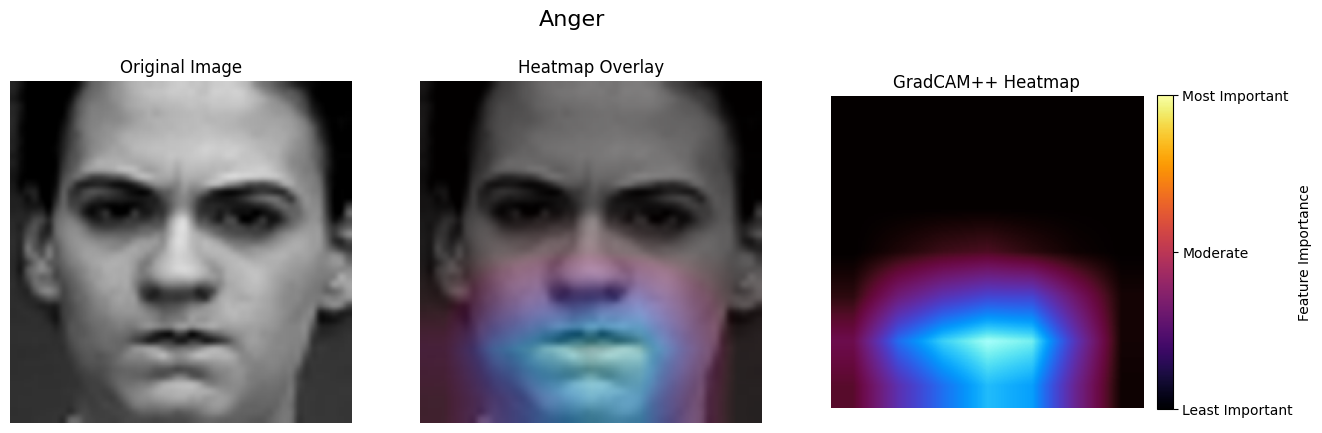

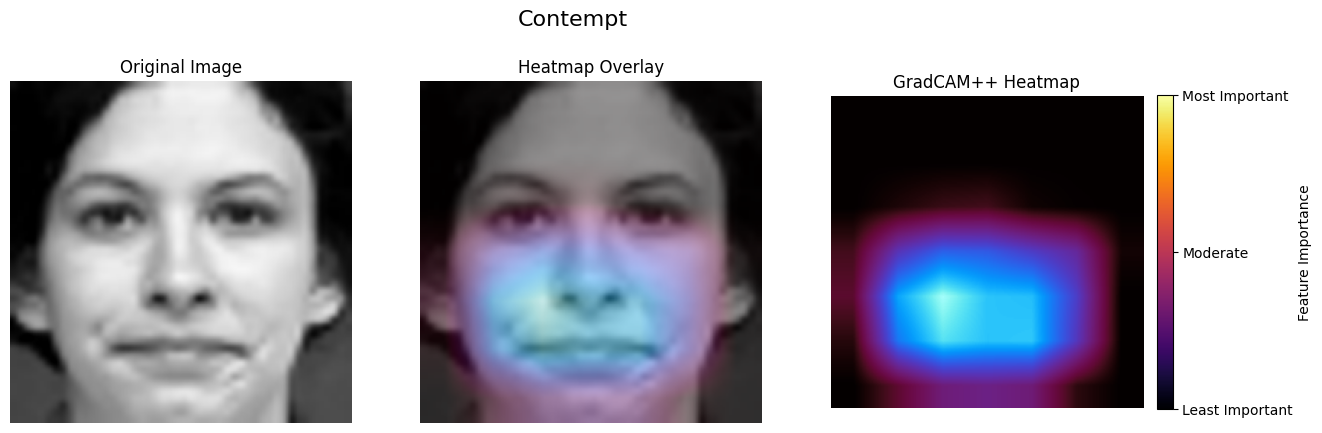

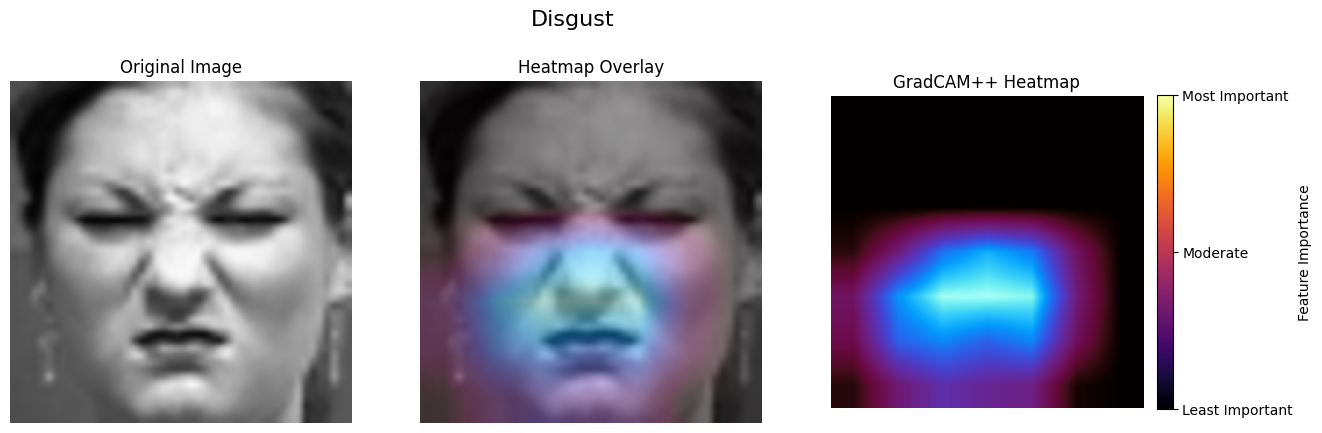

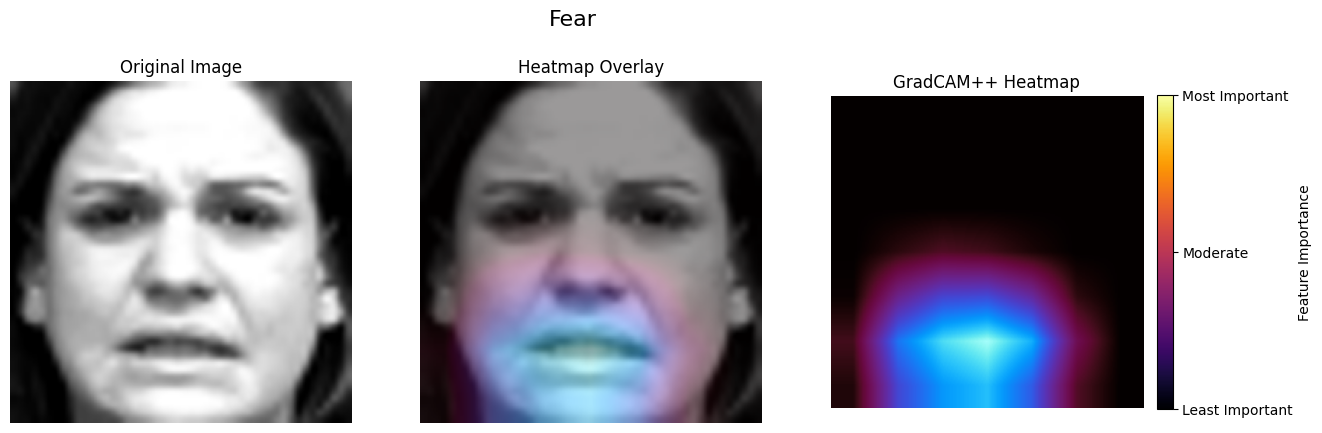

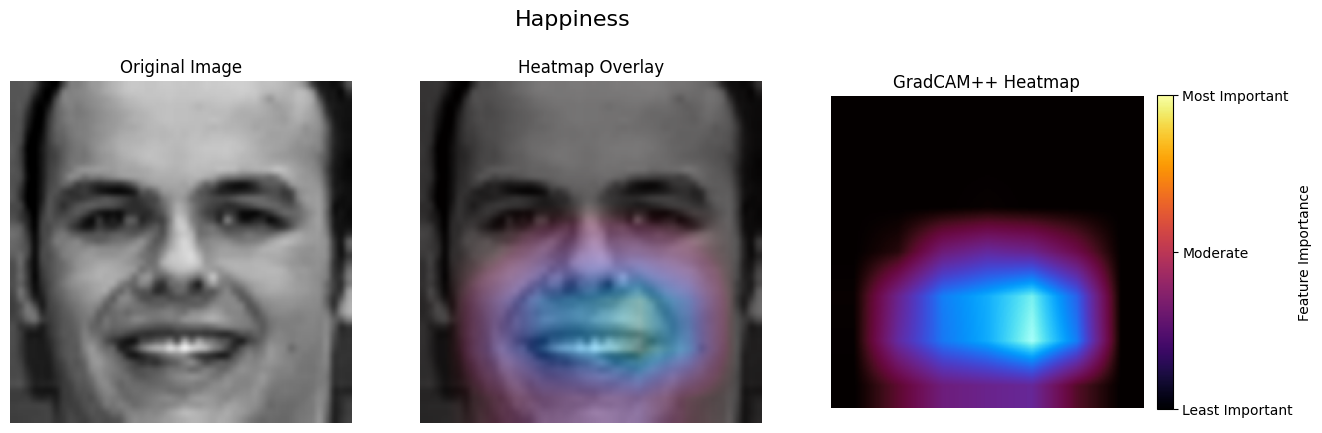

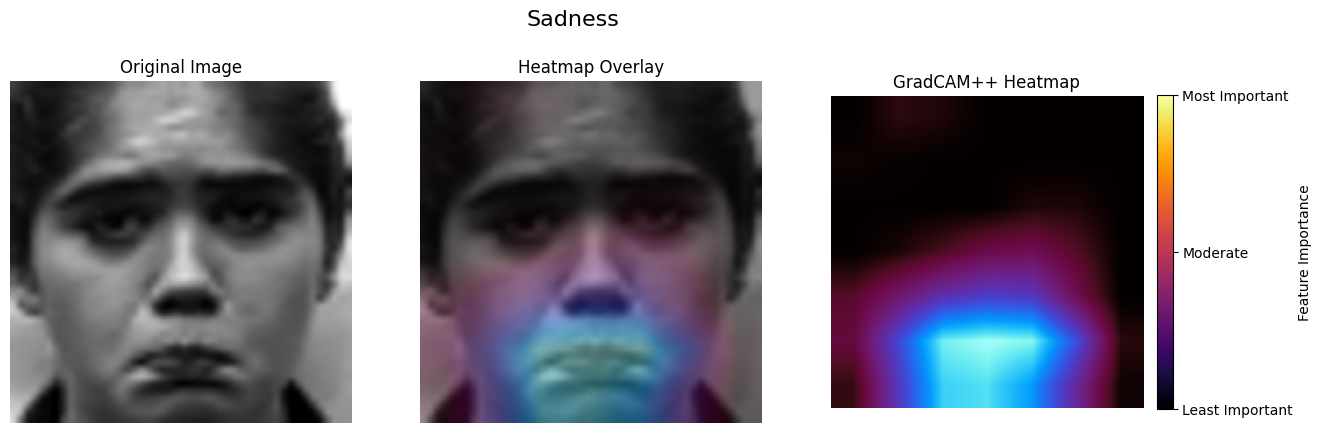

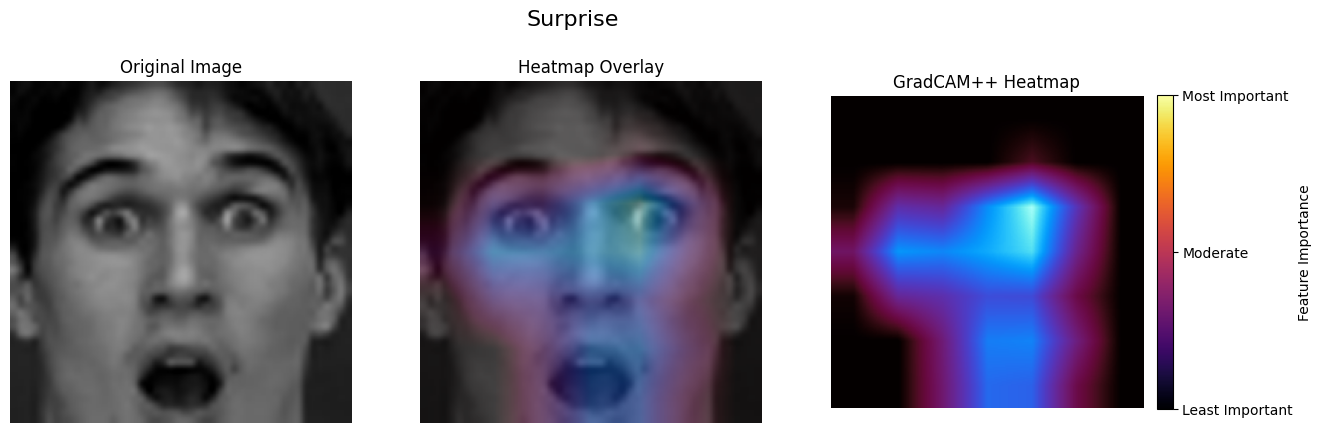

In [10]:
# Plotting with colorbar
for emotion, (original_img, heatmap_overlay, heatmap) in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(emotion.capitalize(), fontsize=16)

    # Original Image
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Heatmap Overlay
    ax[1].imshow(heatmap_overlay)
    ax[1].set_title('Heatmap Overlay')
    ax[1].axis('off')

    # Standalone Heatmap with Colorbar (using 'inferno' colormap)
    heatmap_img = ax[2].imshow(heatmap, cmap='inferno')  # Apply 'inferno' colormap
    ax[2].set_title('GradCAM++ Heatmap')
    ax[2].axis('off')

    # Add colorbar matching the 'inferno' colormap
    cbar = fig.colorbar(heatmap_img, ax=ax[2], fraction=0.046, pad=0.04)
    cbar.set_label('Feature Importance')
    cbar.set_ticks([0, 127.5, 255])  # Add ticks to represent least to most important
    cbar.set_ticklabels(['Least Important', 'Moderate', 'Most Important'])

    plt.show()
